In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa


c:\Users\malon\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [24]:
import tensorflow as tf

# Load the MNIST dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = (y_train == 3) | (y_train == 7)  # Keep only 3 and 7.
y_test = (y_test == 3) | (y_test == 7)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

x_train_flat = x_train.flatten()
x_test_flat = x_test.flatten()
ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define the model.
logistic_regression = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(units=1, activation='sigmoid'),
])
model = logistic_regression
model.summary()

# Compile the model.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model.
#model.fit(x_train, y_train, epochs=1, validation_data=(x_test, y_test))
model.fit(ds_train, epochs=1, validation_data=(x_test, y_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 785       
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


ValueError: in user code:

    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\training.py", line 853, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\training.py", line 842, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\training.py", line 835, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\training.py", line 787, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1037, in __call__
        outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\sequential.py", line 369, in call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\functional.py", line 414, in call
        return self._run_internal_graph(
    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\functional.py", line 550, in _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1020, in __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    File "c:\Users\malon\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_5 is incompatible with the layer: expected axis -1 of input shape to have value 784 but received input with shape (28, 28)


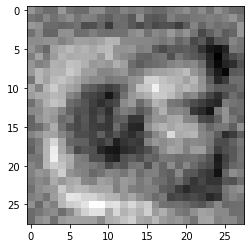

In [17]:
import matplotlib.pyplot as plt

# Get the weights of the model
weights = model.get_weights()

# Plot the weights as a 2D plot
plt.imshow(weights[0].reshape(28, 28), cmap='gray')
plt.show()

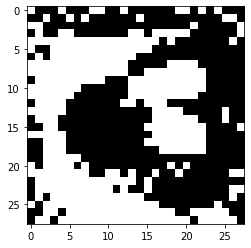

In [18]:
import numpy as np

# Plot the sign of the weights as a 2D plot
plt.imshow(np.sign(weights[0]).reshape(28, 28), cmap='gray')
plt.show()

In [19]:
def get_adversial_exemple(model, dataset, eps):
  adversarial_examples = []
  for images, labels in dataset:
    with tf.GradientTape() as tape:
      tape.watch(images)
      predictions = model(images)
      loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)
    adversarial_example = images + eps * signed_grad
    adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)
    adversarial_examples.append(adversarial_example)
  adversarial_examples = np.concatenate(adversarial_examples,axis=0)
  return adversarial_examples

In [20]:
X_train_adv = get_adversial_exemple(model, ds_train, eps=0.25)
X_train_adv = np.array(X_train_adv)
X_test_adv = get_adversial_exemple(model, ds_test, eps=0.25)
X_test_adv = np.array(X_test_adv)

ValueError: Input 0 of layer dense_3 is incompatible with the layer: expected axis -1 of input shape to have value 784 but received input with shape (28, 28)

NameError: name 'x_test' is not defined

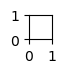

In [ ]:
#Afficher les images
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
plt.figure(1)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.figure(2)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test_adv[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.show()

# Régression logistique pour classer 3 et 7
https://github.com/msotaquira/binary-logistic-regression-with-MNIST/blob/master/binary-logistic-regression-MNIST.py

In [ ]:
X_train_adv = [get_adversial_exemple(model, x, y,eps=0.25).numpy()[0] for x,y in zip(X_train, Y_train)]
X_train_adv = np.array(X_train_adv)
X_test_adv = [get_adversial_exemple(model, x, y,eps=0.25).numpy()[0] for x,y in zip(X_test, Y_test)]
X_test_adv = np.array(X_test_adv)

InvalidArgumentError: Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 [Op:SparseSoftmaxCrossEntropyWithLogits]

Epoch 1/30
13/13 - 0s - loss: 0.5108 - accuracy: 0.8805
Epoch 2/30
13/13 - 0s - loss: 0.3311 - accuracy: 0.9822
Epoch 3/30
13/13 - 0s - loss: 0.2431 - accuracy: 0.9894
Epoch 4/30
13/13 - 0s - loss: 0.1925 - accuracy: 0.9914
Epoch 5/30
13/13 - 0s - loss: 0.1601 - accuracy: 0.9921
Epoch 6/30
13/13 - 0s - loss: 0.1376 - accuracy: 0.9923
Epoch 7/30
13/13 - 0s - loss: 0.1212 - accuracy: 0.9923
Epoch 8/30
13/13 - 0s - loss: 0.1088 - accuracy: 0.9925
Epoch 9/30
13/13 - 0s - loss: 0.0990 - accuracy: 0.9927
Epoch 10/30
13/13 - 0s - loss: 0.0910 - accuracy: 0.9927
Epoch 11/30
13/13 - 0s - loss: 0.0844 - accuracy: 0.9928
Epoch 12/30
13/13 - 0s - loss: 0.0789 - accuracy: 0.9928
Epoch 13/30
13/13 - 0s - loss: 0.0742 - accuracy: 0.9928
Epoch 14/30
13/13 - 0s - loss: 0.0701 - accuracy: 0.9927
Epoch 15/30
13/13 - 0s - loss: 0.0666 - accuracy: 0.9931
Epoch 16/30
13/13 - 0s - loss: 0.0635 - accuracy: 0.9931
Epoch 17/30
13/13 - 0s - loss: 0.0607 - accuracy: 0.9931
Epoch 18/30
13/13 - 0s - loss: 0.0582 - 

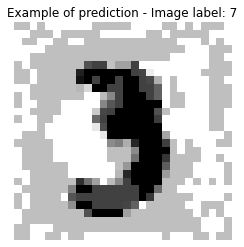

In [ ]:
## Build the model

# - Input layer: 784 nodes (since each image has 28x28 = 784 pixels)
# - Output layer: 1 node with sigmoid activation (output labeled as '0' or '1')
# - No hidden layers

np.random.seed(3)		# fix random seed for reproducibility

input_dim = X_train_adv.shape[1]
output_dim = 1 							

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Dense(output_dim, input_dim = input_dim, activation='sigmoid'))

# Compile  and train the model
sgd = tf.keras.optimizers.SGD(lr=0.01)
model2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

num_epochs = 30
batch_size = 1024
history = model2.fit(X_train_adv, Y_train, epochs=num_epochs, batch_size=batch_size, verbose=2)

# Evaluate and predict
score = model2.evaluate(X_test_adv, Y_test, verbose=0) 
print('Test accuracy:', score[1])

Y_pred = model2.predict(X_test_adv)

# Plot one example of prediction
img_number = 10
if Y_pred[img_number] == 0.0:
	predicted_class = 3
else:
	predicted_class = 7

plt.imshow(X_test_adv[img_number,:].reshape(28,28), cmap="gray_r")
plt.title('Example of prediction - Image label: ' + str(predicted_class))
plt.axis('off')
plt.show()